In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np




from matplotlib import rc
BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])
def compute_complex_response(
    positions,
    arms,          # photon propagation directions n̂
    arm_lengths,
    f_gw,          
    A_plus,
    A_cross,
    theta,
    phi_sky,
    psi=0
):
    # GW propagation vector
    k = -np.array([
        np.sin(theta) * np.cos(phi_sky),
        np.sin(theta) * np.sin(phi_sky),
        np.cos(theta)
    ])

    # Basis vectors perpendicular to k
    if np.allclose(k, [0, 0, 1]):
        ex = np.array([1.0, 0.0, 0.0])
    else:
        ex = np.cross([0, 0, 1], k)
        ex /= np.linalg.norm(ex)
    ey = np.cross(k, ex)

    # Polarization tensors
    e_plus = np.outer(ex, ex) - np.outer(ey, ey)
    e_cross = np.outer(ex, ey) + np.outer(ey, ex)

    # Rotate by polarization angle psi
    e_plus_rot  = e_plus * np.cos(2 * psi) + e_cross * np.sin(2 * psi)
    e_cross_rot = -e_plus * np.sin(2 * psi) + e_cross * np.cos(2 * psi)

    # --- CLOCK ANTENNA GEOMETRY ---
    # n̂ = photon propagation direction
    nk = np.einsum("di,i->d", arms, k)
    denom = 1.0 - nk

    # Geometry-only detector tensor
    D = 0.5 * np.einsum("di,dj->dij", arms, arms) / denom[:, None, None]

    # Antenna factors
    F_plus  = np.einsum("dij,ij->d", D, e_plus_rot)
    F_cross = np.einsum("dij,ij->d", D, e_cross_rot)

    # Retarded-time phase
    tau = np.dot(positions, k) / c
    
    # Finite-arm transfer function
    phase_delay = 2 * np.pi * f_gw * arm_lengths * denom / c
    transfer = 1.0 - np.exp(-1j * phase_delay)
    
    # Full complex response
    S = (F_plus * A_plus + F_cross * A_cross) \
        * np.exp(-1j * 2 * np.pi * f_gw * tau) \
        * transfer

    return S, nk




In [ ]:


c = 3e8  # speed of light

n_theta = 400
n_phi   = 600

theta_vals = np.linspace(0.001, np.pi-0.001, n_theta)
phi_vals   = np.linspace(0.001, 2*np.pi-0.001, n_phi)

THETA, PHI = np.meshgrid(theta_vals, phi_vals, indexing="ij")

# One arm along x̂
arms = np.array([[1.0, 0.0, 0.0]])

# Arm length
arm_lengths = np.array([1.0e10])  # meters (arbitrary but finite)

# Clock position
positions = np.array([[0.0, 0.0, 0.0]])

# GW frequency
f_gw = 1e-3  # Hz

R_plus  = np.zeros_like(THETA)
R_cross = np.zeros_like(THETA)


for i in range(n_theta):
    for j in range(n_phi):

        th = THETA[i, j]
        ph = PHI[i, j]

        # + polarization only
        S_plus, _ = compute_complex_response(
            positions=positions,
            arms=arms,
            arm_lengths=arm_lengths,
            f_gw=f_gw,
            A_plus=1.0,
            A_cross=0.0,
            theta=th,
            phi_sky=ph,
            psi=0.0
        )

        # × polarization only
        S_cross, _ = compute_complex_response(
            positions=positions,
            arms=arms,
            arm_lengths=arm_lengths,
            f_gw=f_gw,
            A_plus=0.0,
            A_cross=1.0,
            theta=th,
            phi_sky=ph,
            psi=0.0
        )

        R_plus[i, j]  = np.abs(S_plus[0])
        R_cross[i, j] = np.abs(S_cross[0])

def spherical_to_cartesian(R, theta, phi):
    X = R * np.sin(theta) * np.cos(phi)
    Y = R * np.sin(theta) * np.sin(phi)
    Z = R * np.cos(theta)
    return X, Y, Z

Xp, Yp, Zp = spherical_to_cartesian(R_plus,  THETA, PHI)
Xc, Yc, Zc = spherical_to_cartesian(R_cross, THETA, PHI)
Xr, Yr, Zr = spherical_to_cartesian(np.sqrt(R_plus**2+R_cross**2),  THETA, PHI)



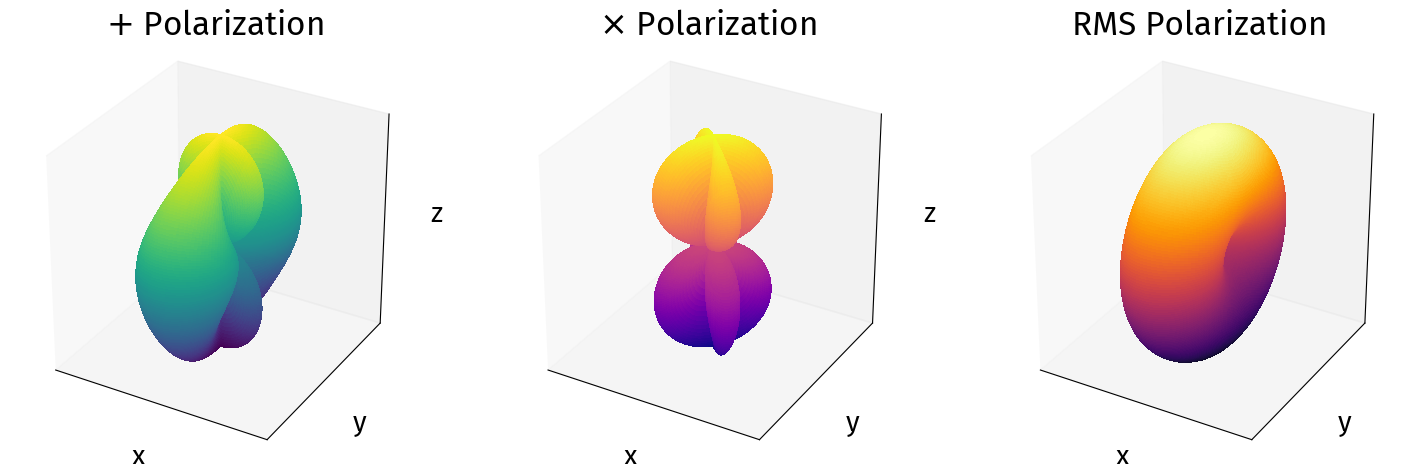

In [103]:
plt.rcParams.update({'font.size': 20})  # sets large text for all labels, titles, legends


# Example normalized surfaces (replace with your computed Xp, Yp, Zp, etc.)
Xp_norm = Xp / np.max(np.abs(Zr))  # normalize by RMS max
Yp_norm = Yp / np.max(np.abs(Zr))
Zp_norm = Zp / np.max(np.abs(Zr))

Xc_norm = Xc / np.max(np.abs(Zr))
Yc_norm = Yc / np.max(np.abs(Zr))
Zc_norm = Zc / np.max(np.abs(Zr))

Xr_norm = Xr / np.max(np.abs(Zr))
Yr_norm = Yr / np.max(np.abs(Zr))
Zr_norm = Zr / np.max(np.abs(Zr))

# Arrow vector: detector arm along x-axis (unit vector)
detector_vector = np.array([1, 0, 0])
arrow_length = 1  # smaller than surface radius to stay inside
arrow_start = np.array([0.0, 0.0, 0.0])  # place inside the surface

lims = [-1, 1]  # equal axis limits

fig = plt.figure(figsize=(18, 6))

def setup_ax(ax, X, Y, Z, cmap, title):
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3,
                    linewidth=0, antialiased=False, cmap=cmap)
    ax.set_title(title)
    ax.set_xlim(lims); ax.set_ylim(lims); ax.set_zlim(lims)
    ax.set_box_aspect([1, 1, 1])
    # Label axes
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# --- Plus polarization ---
ax = fig.add_subplot(131, projection="3d")
setup_ax(ax, Xp_norm, Yp_norm, Zp_norm, cmap="viridis",
         title="$+$ Polarization")

# --- Cross polarization ---
ax2 = fig.add_subplot(132, projection="3d")
setup_ax(ax2, Xc_norm, Yc_norm, Zc_norm, cmap="plasma",
         title=r"$\times$ Polarization")

# --- RMS polarization ---
ax3 = fig.add_subplot(133, projection="3d")
setup_ax(ax3, Xr_norm, Yr_norm, Zr_norm, cmap="inferno",
         title="RMS Polarization")

plt.savefig('plots/antenna_LF.png')

In [104]:
f_gw = 100e-3  # Hz

R_plus  = np.zeros_like(THETA)
R_cross = np.zeros_like(THETA)


for i in range(n_theta):
    for j in range(n_phi):

        th = THETA[i, j]
        ph = PHI[i, j]

        # + polarization only
        S_plus, _ = compute_complex_response(
            positions=positions,
            arms=arms,
            arm_lengths=arm_lengths,
            f_gw=f_gw,
            A_plus=1.0,
            A_cross=0.0,
            theta=th,
            phi_sky=ph,
            psi=0.0
        )

        # × polarization only
        S_cross, _ = compute_complex_response(
            positions=positions,
            arms=arms,
            arm_lengths=arm_lengths,
            f_gw=f_gw,
            A_plus=0.0,
            A_cross=1.0,
            theta=th,
            phi_sky=ph,
            psi=0.0
        )

        R_plus[i, j]  = np.abs(S_plus[0])
        R_cross[i, j] = np.abs(S_cross[0])

def spherical_to_cartesian(R, theta, phi):
    X = R * np.sin(theta) * np.cos(phi)
    Y = R * np.sin(theta) * np.sin(phi)
    Z = R * np.cos(theta)
    return X, Y, Z

Xp, Yp, Zp = spherical_to_cartesian(R_plus,  THETA, PHI)
Xc, Yc, Zc = spherical_to_cartesian(R_cross, THETA, PHI)
Xr, Yr, Zr = spherical_to_cartesian(np.sqrt(R_plus**2+R_cross**2),  THETA, PHI)


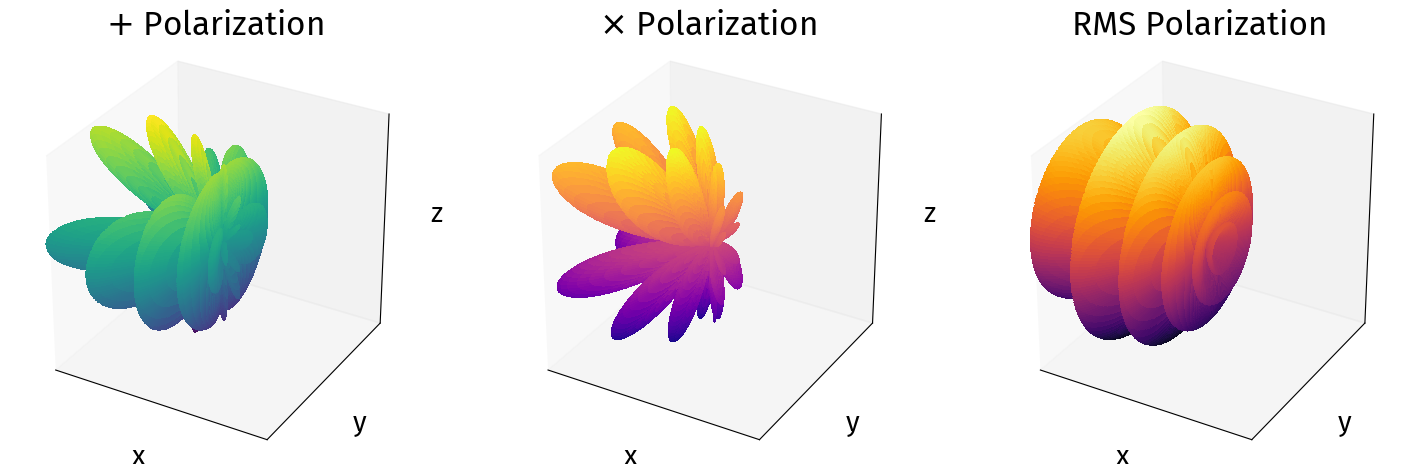

In [105]:
plt.rcParams.update({'font.size': 20})  # sets large text for all labels, titles, legends


# Example normalized surfaces (replace with your computed Xp, Yp, Zp, etc.)
Xp_norm = Xp / np.max(np.abs(Zr))  # normalize by RMS max
Yp_norm = Yp / np.max(np.abs(Zr))
Zp_norm = Zp / np.max(np.abs(Zr))

Xc_norm = Xc / np.max(np.abs(Zr))
Yc_norm = Yc / np.max(np.abs(Zr))
Zc_norm = Zc / np.max(np.abs(Zr))

Xr_norm = Xr / np.max(np.abs(Zr))
Yr_norm = Yr / np.max(np.abs(Zr))
Zr_norm = Zr / np.max(np.abs(Zr))

# Arrow vector: detector arm along x-axis (unit vector)
detector_vector = np.array([1, 0, 0])
arrow_length = 1  # smaller than surface radius to stay inside
arrow_start = np.array([0.0, 0.0, 0.0])  # place inside the surface

lims = [-1, 1]  # equal axis limits

fig = plt.figure(figsize=(18, 6))

def setup_ax(ax, X, Y, Z, cmap, title):
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3,
                    linewidth=0, antialiased=False, cmap=cmap)
    ax.set_title(title)
    ax.set_xlim(lims); ax.set_ylim(lims); ax.set_zlim(lims)
    ax.set_box_aspect([1, 1, 1])
    # Label axes
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

# --- Plus polarization ---
ax = fig.add_subplot(131, projection="3d")
setup_ax(ax, Xp_norm, Yp_norm, Zp_norm, cmap="viridis",
         title="$+$ Polarization")

# --- Cross polarization ---
ax2 = fig.add_subplot(132, projection="3d")
setup_ax(ax2, Xc_norm, Yc_norm, Zc_norm, cmap="plasma",
         title=r"$\times$ Polarization")

# --- RMS polarization ---
ax3 = fig.add_subplot(133, projection="3d")
setup_ax(ax3, Xr_norm, Yr_norm, Zr_norm, cmap="inferno",
         title="RMS Polarization")


plt.savefig('plots/antenna_HF.png', dpi=300)


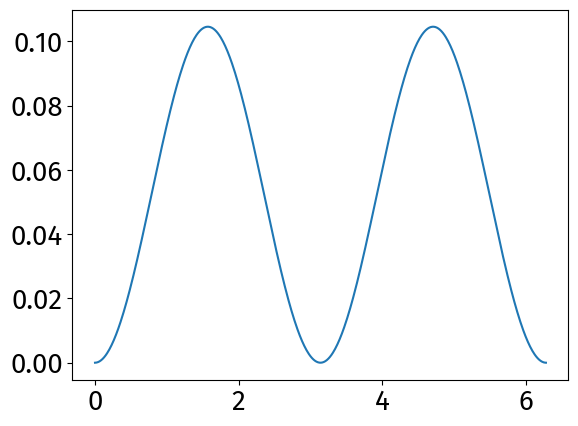

In [129]:
f_gw = 1e-3
F_plus = []
F_cross = []
for phi in phi_vals:
    F_plus.append(compute_complex_response(
                positions=positions,
                arms=arms,
                arm_lengths=arm_lengths,
                f_gw=f_gw,
                A_plus=1.0,
                A_cross=0.0,
                theta=np.pi/2,
                phi_sky=phi,
                psi=0.0
            )[0])
    F_cross.append(compute_complex_response(
                positions=positions,
                arms=arms,
                arm_lengths=arm_lengths,
                f_gw=f_gw,
                A_plus=0.0,
                A_cross=1.0,
                theta=np.pi/2,
                phi_sky=phi,
                psi=0.0
            )[0])
F_rms = np.sqrt(np.abs(F_plus)**2+np.abs(F_cross)**2)
plt.plot(phi_vals,F_rms)


Text(0, 0.5, '$F_\\mathrm{rms}$')

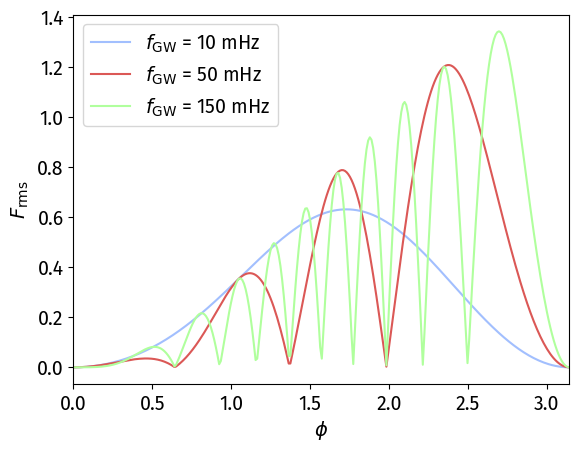

In [15]:

rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f_gws = [10e-3,50e-3,150e-3]

for f_gw in f_gws:
    F_plus = []
    F_cross = []
    for phi in phi_vals:
        F_plus.append(compute_complex_response(
                    positions=positions,
                    arms=arms,
                    arm_lengths=arm_lengths,
                    f_gw=f_gw,
                    A_plus=1,
                    A_cross=0.0,
                    theta=np.pi/2,
                    phi_sky=phi,
                    psi=0.0
                )[0])
        F_cross.append(compute_complex_response(
                    positions=positions,
                    arms=arms,
                    arm_lengths=arm_lengths,
                    f_gw=f_gw,
                    A_plus=0.0,
                    A_cross=1,
                    theta=np.pi/2,
                    phi_sky=phi,
                    psi=0.0
                )[0])
    F_rms = np.sqrt(np.abs(F_plus)**2+np.abs(F_cross)**2)/np.sqrt(2)
    plt.plot(phi_vals,F_rms,alpha = 1, label = '$f_\mathrm{GW}$ = %d mHz'%(f_gw*1e3))

plt.xlim([0,np.pi])
plt.legend()
plt.xlabel('$\phi$')
plt.ylabel('$F_\mathrm{rms}$')
plt.savefig('plots/antenna')

(0.0, 3.141592653589793)

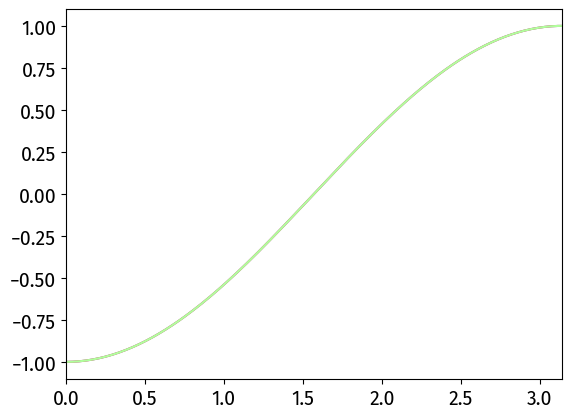

In [7]:

rc('font',**{'family':'sans-serif','sans-serif':['Fira Sans'],'size':14,'style':'normal'})
rc('text', usetex=False)


BLUE = 'xkcd:pastel blue'
RED = 'xkcd:pastel red'
GREEN = 'xkcd:pastel green'
YELLOW ='xkcd:pastel yellow'
PURPLE = 'xkcd:pastel purple'
DBLUE = 'xkcd:light navy blue'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[BLUE, RED, GREEN, YELLOW,PURPLE,DBLUE])

f_gws = [10e-3,50e-3,150e-3]

for f_gw in f_gws:
    F_plus = []
    F_cross = []
    for phi in phi_vals:
        F_plus.append(compute_complex_response(
                    positions=positions,
                    arms=arms,
                    arm_lengths=arm_lengths,
                    f_gw=f_gw,
                    A_plus=1,
                    A_cross=0.0,
                    theta=np.pi/2,
                    phi_sky=phi,
                    psi=0.0
                )[1])
       
    plt.plot(phi_vals,F_plus,alpha = 1)

plt.xlim([0,np.pi])